In [ ]:
import os
import json
import random
import pandas as pd
import numpy as np
from google.colab.patches import cv2_imshow
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from sklearn.preprocessing import LabelEncoder
from scipy import linalg
from google.colab.patches import cv2_imshow
from collections import Counter, defaultdict
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten, Input, AveragePooling2D, Activation, BatchNormalization, Concatenate, SpatialDropout2D
from keras.utils import np_utils
from keras.optimizers import Adam, SGD
from keras.initializers import he_normal, random_normal
from keras.callbacks import LearningRateScheduler, ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from keras.regularizers import l2
import keras.backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import plot_model
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

In [ ]:
os.environ['KAGGLE_USERNAME'] = 'niharikaganji9'
os.environ['KAGGLE_KEY'] = '01f7396c0cbee2f231d642f748c48fda'

!mkdir ~/.kaggle

api_credentials = {
    "username": os.environ['KAGGLE_USERNAME'],
    "key": os.environ['KAGGLE_KEY']
}
with open('/root/.kaggle/kaggle.json', 'w') as f:
    json.dump(api_credentials, f)

!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d bhaskar2443053/fashion-small

 98% 1.22G/1.24G [00:09<00:00, 74.3MB/s]
100% 1.24G/1.24G [00:09<00:00, 140MB/s] 


In [ ]:
import zipfile

with zipfile.ZipFile('fashion-small.zip', 'r') as zip_ref:
    zip_ref.extractall('fashion-small')

In [ ]:
train_target = pd.read_csv('fashion-small/fashion_small/styles.csv', error_bad_lines=False)

<ipython-input-8-51f475534dde>:1: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  train_target = pd.read_csv('fashion-small/fashion_small/styles.csv', error_bad_lines=False)
Skipping line 6044: expected 10 fields, saw 11
Skipping line 6569: expected 10 fields, saw 11
Skipping line 7399: expected 10 fields, saw 11
Skipping line 7939: expected 10 fields, saw 11
Skipping line 9026: expected 10 fields, saw 11
Skipping line 10264: expected 10 fields, saw 11
Skipping line 10427: expected 10 fields, saw 11
Skipping line 10905: expected 10 fields, saw 11
Skipping line 11373: expected 10 fields, saw 11
Skipping line 11945: expected 10 fields, saw 11
Skipping line 14112: expected 10 fields, saw 11
Skipping line 14532: expected 10 fields, saw 11
Skipping line 15076: expected 10 fields, saw 12
Skipping line 29906: expected 10 fields, saw 11
Skipping line 31625: expected 10 fields, saw 11
Skipping line 3302

In [ ]:
l=[]
for i in train_target['id']:
    if not os.path.exists('fashion-small/fashion_small/fashion_small/resized_images/'+str(i) +".jpg"):
        l.append(i)
        train_target.drop(train_target[train_target.id == i].index, inplace=True)

In [ ]:
train_target = train_target.reset_index()
train_target = train_target.drop(['index'], axis=1)

In [ ]:
train_target.tail()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
44414,17036,Men,Footwear,Shoes,Casual Shoes,White,Summer,2013.0,Casual,Gas Men Caddy Casual Shoe
44415,6461,Men,Footwear,Flip Flops,Flip Flops,Red,Summer,2011.0,Casual,Lotto Men's Soccer Track Flip Flop
44416,18842,Men,Apparel,Topwear,Tshirts,Blue,Fall,2011.0,Casual,Puma Men Graphic Stellar Blue Tshirt
44417,46694,Women,Personal Care,Fragrance,Perfume and Body Mist,Blue,Spring,2017.0,Casual,Rasasi Women Blue Lady Perfume
44418,51623,Women,Accessories,Watches,Watches,Pink,Winter,2016.0,Casual,Fossil Women Pink Dial Chronograph Watch ES3050


In [ ]:
matrix = np.zeros((train_target.shape[0], 64*64*3))

for i in range(0,train_target.shape[0]):
  try:
    # print(i)
    image = cv2.imread('fashion-small/fashion_small/fashion_small/resized_images/' + str(train_target['id'][i])+ '.jpg')
    resized_arr = cv2.resize(image, (64,64))
    img_arr = np.array(resized_arr)
    arr = img_arr.reshape(1,64*64*3)
    matrix[i] = arr
  except KeyError:
    print('Item not valid:',i)

In [ ]:
matrix.shape

(44419, 12288)

**Data - Images**

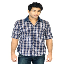

In [ ]:
sample_image_0 = matrix[0]
sample_image_0 = sample_image_0.reshape(64,64,3)
cv2_imshow(sample_image_0)

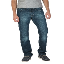

In [ ]:
sample_image_1 = matrix[1]
sample_image_1 = sample_image_1.reshape(64,64,3)
cv2_imshow(sample_image_1)

**Data - Labels**

In [ ]:
train_target.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt


Text(0.5, 1.0, 'Histogram visualising the frequency of each class in the SubCategory feature')

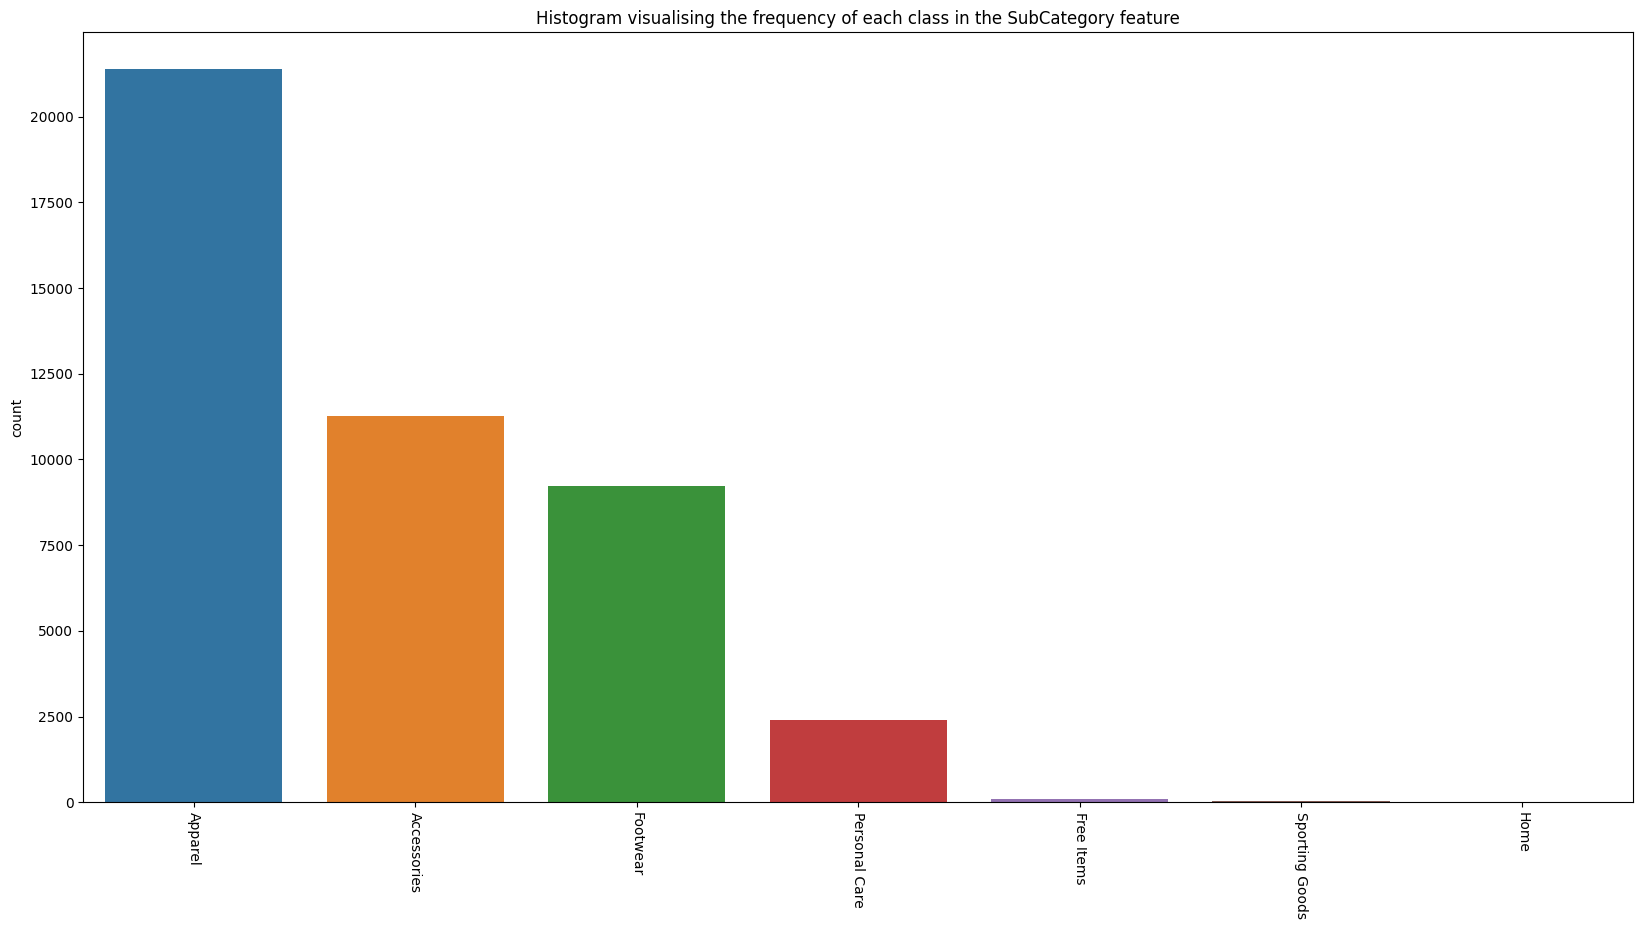

In [ ]:
counts = defaultdict(int)
for l in train_target['masterCategory']:
     counts[l] += 1

frequency = pd.DataFrame.from_dict(counts, orient='index')
frequency.columns = ['count']
frequency.sort_values('count', ascending=False, inplace=True)

fig, ax = plt.subplots()
ax = sns.barplot(x=frequency.index, y=frequency['count'], ax=ax)
fig.set_size_inches(20,10)
ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=-90)
plt.title('Histogram visualising the frequency of each class in the SubCategory feature')

Text(0.5, 1.0, 'Histogram visualising the frequency of each class in the SubCategory feature')

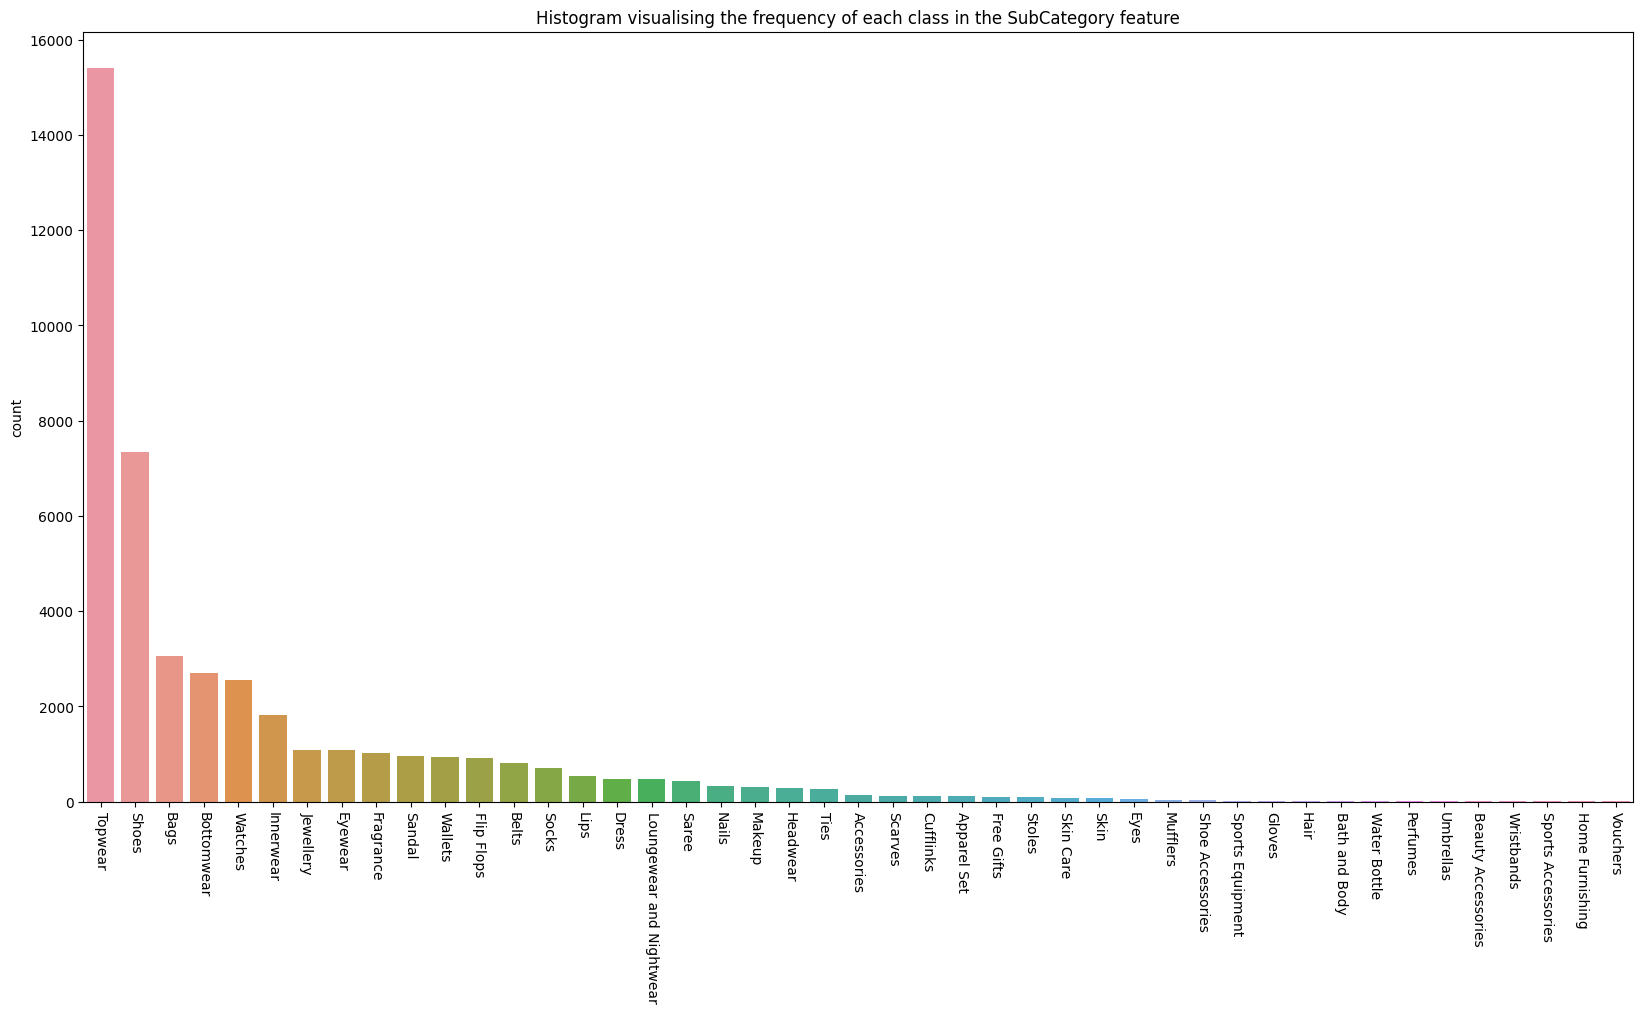

In [ ]:
counts = defaultdict(int)
for l in train_target['subCategory']:
     counts[l] += 1

frequency = pd.DataFrame.from_dict(counts, orient='index')
frequency.columns = ['count']
frequency.sort_values('count', ascending=False, inplace=True)

fig, ax = plt.subplots()
ax = sns.barplot(x=frequency.index, y=frequency['count'], ax=ax)
fig.set_size_inches(20,10)
ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=-90)
plt.title('Histogram visualising the frequency of each class in the SubCategory feature')

Text(0.5, 1.0, 'Histogram visualising the frequency of each class in the SubCategory feature')

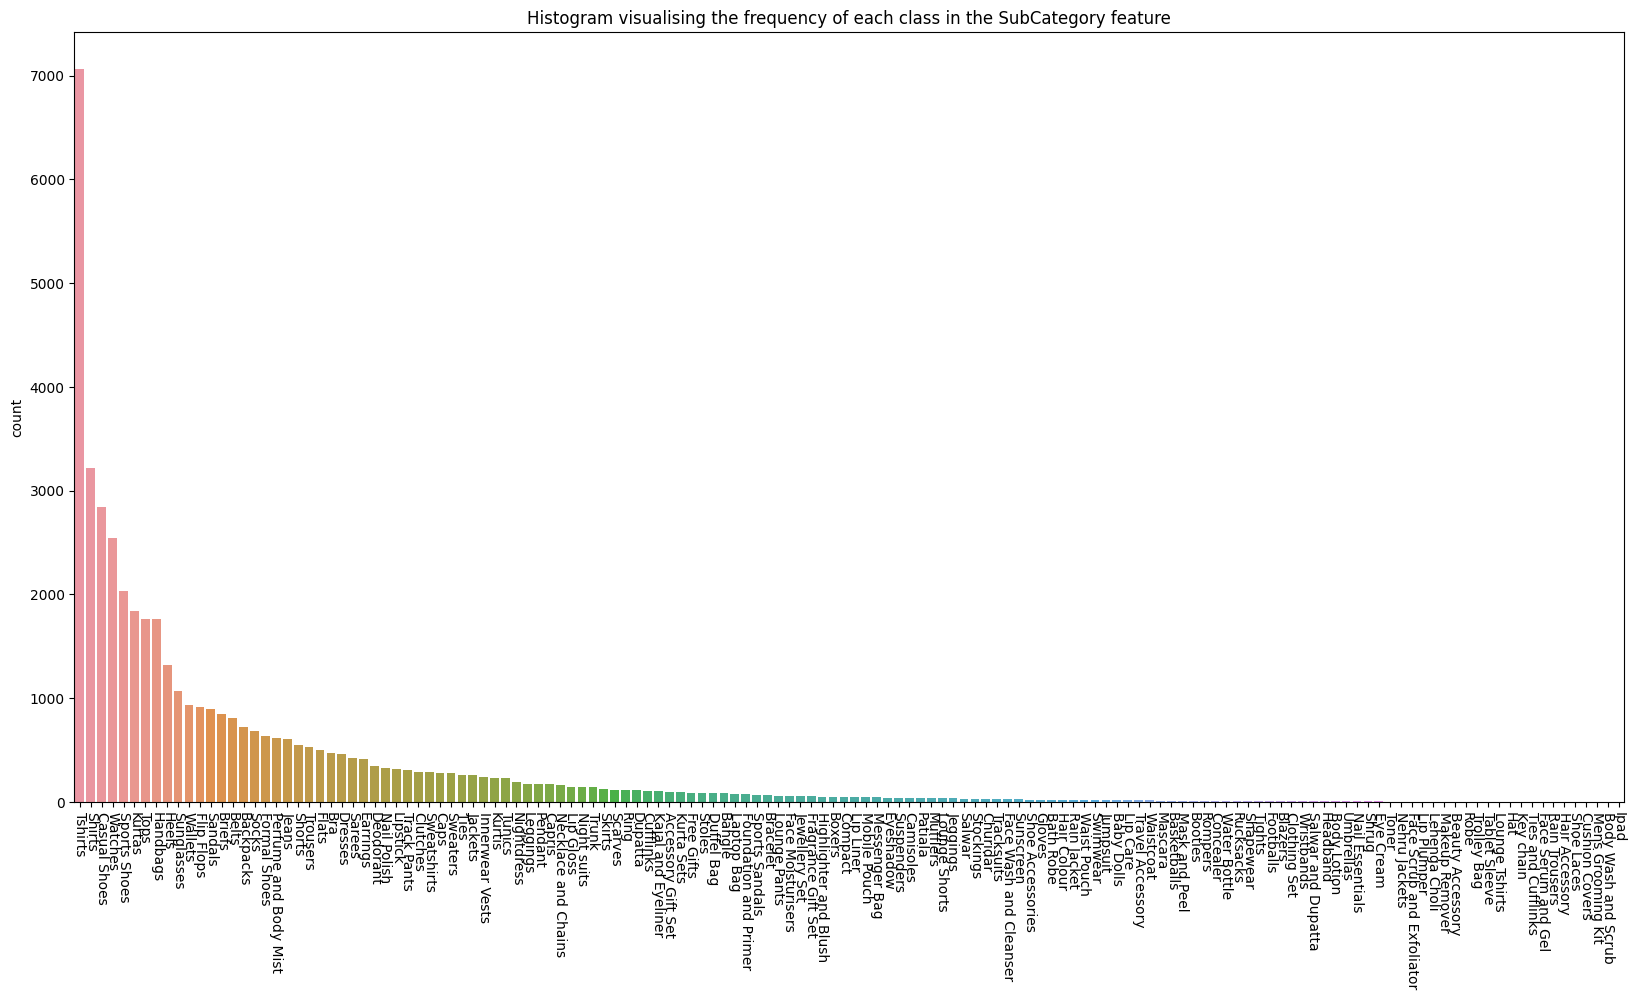

In [ ]:
counts = defaultdict(int)
for l in train_target['articleType']:
     counts[l] += 1

frequency = pd.DataFrame.from_dict(counts, orient='index')
frequency.columns = ['count']
frequency.sort_values('count', ascending=False, inplace=True)

fig, ax = plt.subplots()
ax = sns.barplot(x=frequency.index, y=frequency['count'], ax=ax)
fig.set_size_inches(20,10)
ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=-90)
plt.title('Histogram visualising the frequency of each class in the SubCategory feature')

In [ ]:
#45 classes in the target variable
train_target.nunique()

id                    44419
gender                    5
masterCategory            7
subCategory              45
articleType             142
baseColour               46
season                    4
year                     13
usage                     8
productDisplayName    31116
dtype: int64

In [ ]:
data = pd.DataFrame(matrix)
data.shape

(44419, 12288)

**Data Preprocessing**

**Data Reduction - Class Imbalance**

In [ ]:
#Write reasons
class_balance = train_target.groupby(['subCategory'], as_index = False)['id'].count()
class_balance = class_balance.rename(columns = {'id':'frequency'})

In [ ]:
categories = class_balance[class_balance['frequency']>1003]
categories

,subCategory,frequency
2,Bags,3055
6,Bottomwear,2693
10,Eyewear,1073
12,Fragrance,1011
18,Innerwear,1808
19,Jewellery,1079
30,Shoes,7343
38,Topwear,15398
42,Watches,2542


In [ ]:
filtered_target = train_target[train_target['subCategory'].isin(categories['subCategory'])]

In [ ]:
data = data.iloc[filtered_target.index,:].reset_index()
data = data.drop(['index'], axis=1)

In [ ]:
filtered_target = filtered_target.reset_index()
filtered_target = filtered_target.drop(['index'], axis=1)

In [ ]:
filtered_target.shape

(36002, 10)

In [ ]:
data.shape

(36002, 12288)

**Label Encoding**

In [ ]:
#Label encoding our target variable as we want it to be class
encoder = LabelEncoder()
# filtered_target['subCategory'] = encoder.fit_transform(filtered_target['subCategory'])
# n_classes = len(set(filtered_target['subCategory']))
# filtered_target = np.asarray(filtered_target['subCategory'])

**PCA**

In [ ]:
class PCA():
    def __init__(self, n_components=None):
        self.n_components = n_components
        self.variance=None

    def fit(self, X):
        self.mean = np.mean(X, axis=0)
        X = X - self.mean
        covariance = np.cov(X, rowvar = False)
        self.eigen_values, self.eigen_vectors = linalg.eig(covariance)
        idx_order = np.argsort(self.eigen_values)[::-1]
        self.eigen_vectors_tranpose = self.eigen_vectors.transpose()

    def transform(self, X):
        X = X - self.mean
        self.eigen_values=self.eigen_values[:self.n_components]
        total_eigenvalues = sum(self.eigen_values)
        self.variance = [(i/total_eigenvalues)*100 for i in self.eigen_values]
        cum_sum_exp = np.cumsum(self.variance)
        return np.dot(X, self.eigen_vectors[:, :self.n_components])

    def inverse_transform(self, X):
        return np.dot(X, self.eigen_vectors_tranpose[:self.n_components]) + self.mean

In [ ]:
train_data = data
train_data = np.asarray(train_data)
train_data = train_data.reshape(data.shape[0], 64, 64,3)

reduced_images = np.zeros((train_data.shape[0], 64,64,3))

components=10
for i in range(train_data.shape[0]):

  blue_array,green_array,red_array=cv2.split(train_data[i])

  pca = PCA(components)
  pca.fit(blue_array)
  X_projected = pca.transform(blue_array)
  X_projected_inversed_blue = pca.inverse_transform(X_projected)
  cum_sum_exp_blue = np.cumsum(pca.variance)

  pca = PCA(components)
  pca.fit(green_array)
  X_projected = pca.transform(green_array)
  X_projected_inversed_green = pca.inverse_transform(X_projected)
  cum_sum_exp_green = np.cumsum(pca.variance)


  pca = PCA(components)
  pca.fit(red_array)
  X_projected = pca.transform(red_array)
  X_projected_inversed_red = pca.inverse_transform(X_projected)
  cum_sum_exp_red = np.cumsum(pca.variance)

  img_after_pca = np.dstack((X_projected_inversed_blue, X_projected_inversed_green, X_projected_inversed_red))
  reduced_images[i] = img_after_pca

<ipython-input-31-558e78701afa>:32: ComplexWarning: Casting complex values to real discards the imaginary part
  reduced_images[i] = img_after_pca
<ipython-input-30-1241e105209f>:18: RuntimeWarning: invalid value encountered in cdouble_scalars
  self.variance = [(i/total_eigenvalues)*100 for i in self.eigen_values]


In [ ]:
data_reduced = reduced_images
data_reduced.shape

(36002, 64, 64, 3)

In [ ]:
#Original data shape
data.shape

(36002, 12288)

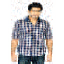

In [ ]:
cv2_imshow(data_reduced[0])

**Feature Creation**

In [ ]:
filtered_target.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt


In [ ]:
filtered_target['labels'] = filtered_target['subCategory'] + filtered_target['gender']

In [ ]:
filtered_target.nunique()

id                    36002
gender                    5
masterCategory            4
subCategory               9
articleType              75
baseColour               46
season                    4
year                     12
usage                     7
productDisplayName    25107
labels                   39
dtype: int64

**Visual Similarity Search using PCA Reduced Data**

In [ ]:
#Flattening the data to send into KNN
data_reduced = data_reduced.reshape(data_reduced.shape[0],64*64*3)
data_reduced.shape

(36002, 12288)

In [ ]:
encoder = LabelEncoder()
filtered_target['Encoded_labels'] = encoder.fit_transform(filtered_target['labels'])
n_classes = len(set(filtered_target['labels']))

In [ ]:
model = KNeighborsClassifier(n_neighbors=7)
model.fit(data_reduced,filtered_target['Encoded_labels'])

KNeighborsClassifier(n_neighbors=7)

**Given an image from the dataset**

Input Image


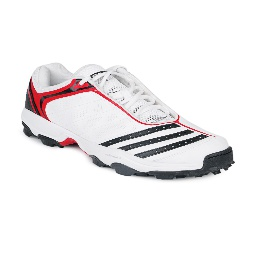

Output Images


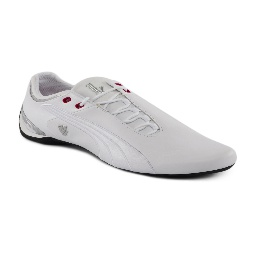

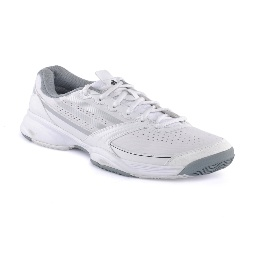

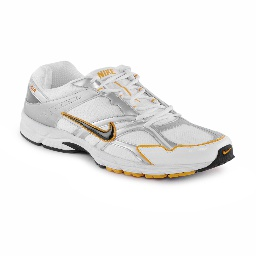

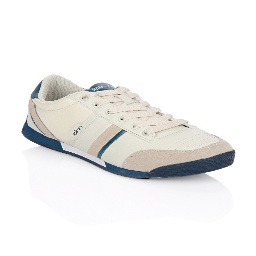

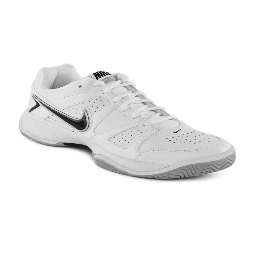

In [ ]:
i = random.randint(0,data_reduced.shape[0])

image_id = filtered_target.iloc[i,:]['id']
image_path = 'fashion-small/fashion_small/fashion_small/resized_images/' + str(image_id)+ '.jpg'
image = cv2.imread(image_path)
print('Input Image')
cv2_imshow(image)

dist, index = model.kneighbors(X=data_reduced[i].reshape(1,-1))
print('Output Images')
for i in range(1,6):
    image_id = filtered_target.iloc[index[0][i],:]['id']
    image_path = 'fashion-small/fashion_small/fashion_small/resized_images/' + str(image_id)+ '.jpg'
    image = cv2.imread(image_path)
    cv2_imshow(image)

**Given a new image**

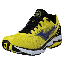

In [ ]:
outside_image = cv2.imread('shoe.jpg')
image = cv2.resize(outside_image, (64,64))
cv2_imshow(image)

In [ ]:
blue_array,green_array,red_array=cv2.split(image)

pca = PCA(components)
pca.fit(blue_array)
X_projected = pca.transform(blue_array)
X_projected_inversed_blue = pca.inverse_transform(X_projected)
cum_sum_exp_blue = np.cumsum(pca.variance)

pca = PCA(components)
pca.fit(green_array)
X_projected = pca.transform(green_array)
X_projected_inversed_green = pca.inverse_transform(X_projected)
cum_sum_exp_green = np.cumsum(pca.variance)


pca = PCA(components)
pca.fit(red_array)
X_projected = pca.transform(red_array)
X_projected_inversed_red = pca.inverse_transform(X_projected)
cum_sum_exp_red = np.cumsum(pca.variance)

img_after_pca = np.dstack((X_projected_inversed_blue, X_projected_inversed_green, X_projected_inversed_red))

/usr/local/lib/python3.10/dist-packages/google/colab/patches/__init__.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
  a = a.clip(0, 255).astype('uint8')


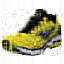

In [ ]:
cv2_imshow(img_after_pca)
image =np.real(img_after_pca)

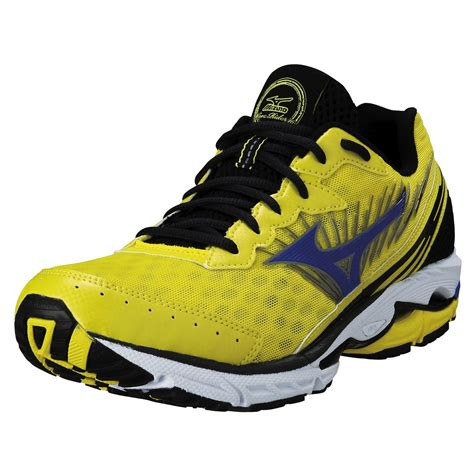

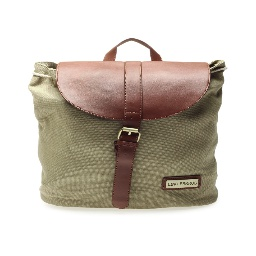

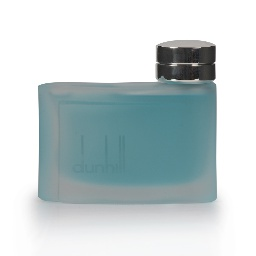

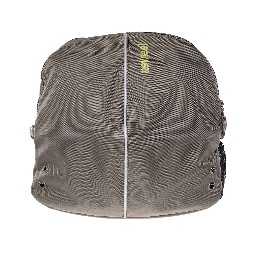

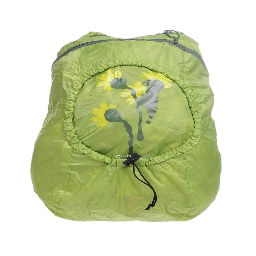

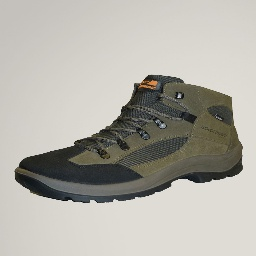

In [ ]:
cv2_imshow(outside_image)

dist, index = model.kneighbors(X=image.reshape(1,-1))
for i in range(1,6):
    image_id = filtered_target.iloc[index[0][i],:]['id']
    image_path = 'fashion-small/fashion_small/fashion_small/resized_images/' + str(image_id)+ '.jpg'
    image = cv2.imread(image_path)
    cv2_imshow(image)

**Other observations**